In [1]:
#import and setup
import pandas as pd
import os
import matplotlib.pyplot as plt # for graphs
%matplotlib inline

In [2]:
from datetime import date
from datetime import datetime

now = datetime.now()
# dd/mm/YY H:M:S
dt_string = now.strftime("%d%m%Y%H%M%S")

today = date.today()
strToday = str(today.strftime('%Y-%m-%d'))
yearAgo = date(today.year - 1, today.month, today.day)
strYearAgo = str(yearAgo.strftime('%Y-%m-%d'))
start_date = strYearAgo
end_date = strToday

In [3]:
#alphavntage
from alpha_vantage.timeseries import TimeSeries

API_key = 'LMP6ND8IA11NAI2D'
ts = TimeSeries(key=API_key,output_format='pandas') # create time series object. pandas is output fromat

name = 'teva'

df, meta = ts.get_monthly_adjusted(name) # data - tpe dataframe
df = df.rename(columns={'4. close': 'Close'})
df = df[(df.index > start_date) & (df.index <= end_date)]
df = df.sort_index(ascending=True)

df

,1. open,2. high,3. low,Close,5. adjusted close,6. volume,7. dividend amount
date,,,,,,,
2020-05-29,10.59,13.230,9.72,12.53,12.53,271358068.0,0.0
2020-06-30,12.58,13.200,10.88,12.33,12.33,200331637.0,0.0
2020-07-31,12.32,12.820,11.11,11.54,11.54,172420754.0,0.0
2020-08-31,11.51,12.810,9.03,9.87,9.87,236590394.0,0.0
2020-09-30,9.85,9.900,8.46,9.01,9.01,162120997.0,0.0
2020-10-30,9.06,10.090,8.46,8.72,8.72,143454912.0,0.0
2020-11-30,8.79,9.885,8.44,9.51,9.51,195403341.0,0.0
2020-12-31,9.58,11.070,9.26,9.65,9.65,164867148.0,0.0
2021-01-29,9.71,12.660,9.71,11.78,11.78,203687327.0,0.0


In [4]:
closing_prices = df.Close # takes column labelled 'Close'

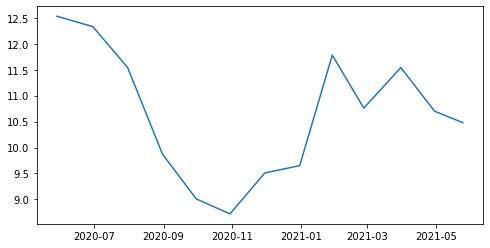

In [5]:
# plot closing prices
plt.figure(figsize=(8,4)) # size of graph
plt.plot(df['Close'],label = 'close price history',alpha=1) # show 

In [6]:
class movAvg():
    def __init__(self, closing_prices):
        self.data = pd.DataFrame(closing_prices)

    # This implementation sets the default averaging length to 50 days 
    # returns a data-frame of the averaged prices with their corresponding date index
    # calculate 50 days 
    def EMA(self, averaging_length=50):
        ret = self.data.ewm( span=averaging_length, adjust=False).mean()
        return ret.rename(columns={'Close': 'EMA'})

    # calculate the MACD line, signal line and histogram
    def MACD(self, a=12, b=26, c=9):
        MACD_line = self.EMA(a) - self.EMA(b)
        signal_line = MACD_line.ewm(span=c, adjust=False).mean()
        histogram = MACD_line - signal_line
        return MACD_line, signal_line, histogram

# Executing class

MACD_indicator = movAvg(closing_prices)
MACD_line, signal_line, histogram = MACD_indicator.MACD()

In [7]:
import itertools
from datetime import datetime

class stock_baught():
    
    id=0

    def __init__(self, ticker, price, shares, buyDate):
        self.ticker = ticker
        self.buyDate =  buyDate.strftime("%d/%m/%Y, %H:%M:%S")
        self.price = price
        self.shares = shares
        self.objID=stock_baught.id
        self.moneySpent = self.shares*self.price
        stock_baught.id=stock_baught.id+1

    def check_profit15(self, price):
        if(self.price*1.15<price):
            return 1
        return 0


class Portofolio():

    transactionFees = 5.50

    def __init__(self, balance, botMoney):
        self.startBalance = balance
        self.balance = balance
        self.botMoney = botMoney # money for bot to invest
        self.stocks = []
        self.log_index=0
        self.log = []

    def buyStock(self, stockBaught):
        self.stocks.append(stockBaught)
        self.balance=self.balance-stockBaught.moneySpent-Portofolio.transactionFees
        self.botMoney=self.botMoney-stockBaught.moneySpent-Portofolio.transactionFees

        # write in log
        text = "baught stock "+str(stockBaught.id)+" "+str(stockBaught.ticker)+" in date "+str(stockBaught.buyDate)+" at price "+str(stockBaught.price)+" so i have "+str(stockBaught.shares)+" shares"+" . balance =  "+str(self.balance)
        self.log.append(text)

    def sellStock(self, stockBaught, currentPrice, sellDate, sellPercentage):
         j=0
         for i in self.stocks:
            if i.objID==stockBaught.objID:
                if sellPercentage==1:
                    self.stocks.remove(i)
                    j=j-1
                else:
                    self.stocks[j].shares=self.stocks[j].shares/2
                self.botMoney=self.botMoney-Portofolio.transactionFees+currentPrice*(sellPercentage)
                self.balance=self.balance-Portofolio.transactionFees+currentPrice*(sellPercentage)

                # write in log
                text = "sold " + str(sellPercentage) + " percent of stock " + str(stockBaught.id) + " " + str(i.ticker) + "when it was "+str(currentPrice)+ " in date " +str(sellDate)+ str(currentPrice-stockBaught.price)  + " . balance =  " +str(self.balance)  
                self.log.append(text)   
                print("appended")
         j = j+1

    def endTradeSession(self, date, today_close_price):

        # sell all stocks
        sellPercentage = 1
        for i in self.stocks:
            self.sellStock(i, today_close_price, date, sellPercentage)

        # print log
        for i in range(len(self.log)):
            print("\n",self.log[i])

        # print results
        print("\n started with ",str(self.startBalance)," and finished at ", str(self.balance))
        
        # change start balance to current balance
        self.startBalance=self.balance


money_in_portofolio = 20000
bot_money = 5000
porto = Portofolio(money_in_portofolio, bot_money)

In [8]:
buy = pd.DataFrame(index=closing_prices.index, columns=['Buy']) # an empty data-frame to store buy signals
sell = pd.DataFrame(index=closing_prices.index, columns=['Sell']) # an empty data-frame to store sell signals

for i in range(1, len(closing_prices)): 
    today_close_price = closing_prices[i]

    if i == 1: # ignores first value of historical data as MACD will be equal to signal line there
        if MACD_line['EMA'].iloc[i] > signal_line['EMA'].iloc[i]:
            high = 'MACD'
        else:
            high = 'SIGNAL'
    elif MACD_line['EMA'].iloc[i] > signal_line['EMA'].iloc[i]:
        if high == 'SIGNAL': # MACD crossed signal - bottom to top BUY
            if MACD_line['EMA'].iloc[i] < 0 and  porto.botMoney>porto.transactionFees*10: # have money 
                buy.iloc[i] = closing_prices[i] # BUY
            high = 'MACD'
    elif MACD_line['EMA'].iloc[i] < signal_line['EMA'].iloc[i]:
        if high == 'MACD': # MACD crossed signal - top to bottom SELL
            if MACD_line['EMA'].iloc[i] > 0:
                sell.iloc[i] = closing_prices[i] # SELL
            high = 'SIGNAL'

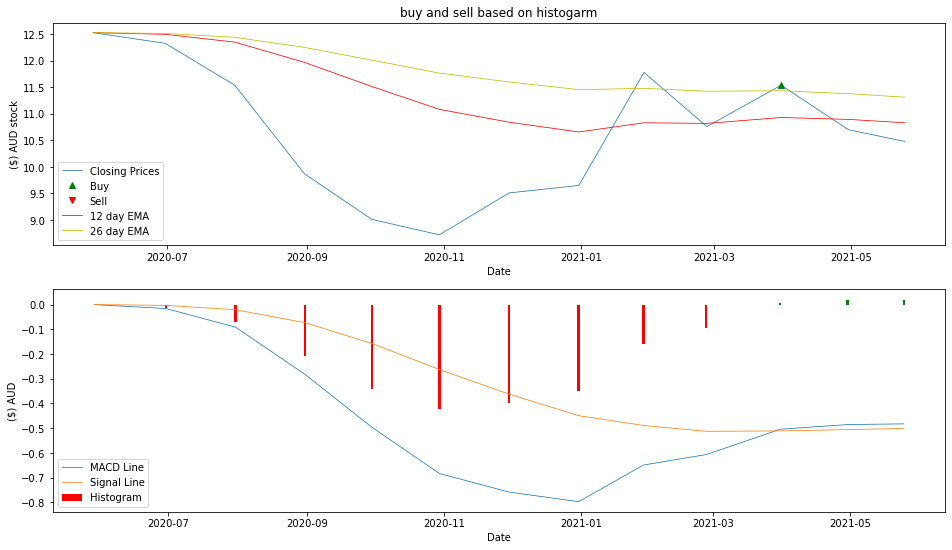

In [9]:
# Plotting results 
plt.rcParams["figure.figsize"] = [16,9] # size of graph
plt.rcParams["lines.linewidth"] = 0.75

fig, (ax1, ax2) = plt.subplots(2) # Create a figure and a set of subplots

# subplot 1 - shows where to buy and sell (based on where MACD and signal line meet)
ax1.plot(closing_prices, label = 'Closing Prices') # add closing_prices line to graph
ax1.plot(buy, 'g^', label = 'Buy')
ax1.plot(sell, 'rv', label = 'Sell')
ax1.plot(MACD_indicator.EMA(12), 'r', label = '12 day EMA') #  plot the 12 day EMA 
ax1.plot(MACD_indicator.EMA(26), 'y', label = '26 day EMA') #  plot the 26 day EMA 
ax1.legend(loc='lower left') # legend is an area describing the elements of the graph.
ax1.title.set_text('buy and sell based on histogarm')
ax1.set(xlabel='Date', ylabel='($) AUD stock')

# subplot 2 
ax2.plot(MACD_line, label = 'MACD Line')
ax2.plot(signal_line, label = 'Signal Line')
histogram_y = [histogram['EMA'].iloc[i] for i in range(0, len(histogram))]
 # green if histogram is above zero and red if hhistogram is below zero
ax2.bar(histogram.index, histogram_y, 
        color=['g' if histogram_y[i] > 0 else 'r' for i in range(0,len(histogram_y))],
        width = 1, label = 'Histogram')
ax2.legend(loc='lower left')
ax2.set(xlabel='Date', ylabel='($) AUD')

plt.show()


1.5